In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def mediapipeimg(image):

  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    results = hands.process(image)
    # print('Handedness:', results.multi_handedness)



    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    landmark_tangan=[]
    for hand_landmarks in results.multi_hand_landmarks:
     
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      fitur = []
      data = []
      for h in range(0,20):
          x = hand_world_landmarks.landmark[h].x
          y = hand_world_landmarks.landmark[h].y
          z = hand_world_landmarks.landmark[h].z
          fitur.append(x)
          fitur.append(y)
          fitur.append(z)
      data.extend(fitur)
      x = 0
      y = 0
      z = 0



    return results, annotated_image, data

In [3]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='../gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr



In [4]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        if self.featureExtraction:
            feature, err = self.featureExtraction(image)
            if (err != None):
                return self.__getitem__(idx + 1)
            else:
                custom_features = feature
        
        
        hasil = {
            'image': image,
            'labels': label,
            'id_class': idx,
            'custom_features': custom_features,
            'data': data
        }
        
        return hasil

In [5]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../../dataset/SIBI/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/training/", transform=train_transform, featureExtraction=handGesture)

print(type(dataset))

<class '__main__.dawtaset'>


In [6]:
# #Visualizing some examples in the training dataset X
# from random import randrange
# fig, ax = plt.subplots(nrows = 2, ncols = 5,  figsize = (15,8))
# for i in range(5):
#     a = randrange(2000)
#     hasil = dataset.__getitem__(a)
    
#     ax[0,i].imshow(hasil["image"].T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
#     ax[0,i].set_title(int(hasil["labels"]))
    

# ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})

In [7]:
# hasil = dataset.__getitem__(1)
# idx_to_class = {v: k for k, v in hasil["data"].class_to_idx.items()}

# def get_class_distribution(dataset):
#     count_dict = {k:0 for k,v in hasil["data"].class_to_idx.items()} # initialise dictionary
    
#     for input, label in hasil["data"]:
#         label = idx_to_class[label]
#         count_dict[label] += 1
            
#     return count_dict

# print("Distribution of classes: ", get_class_distribution(hasil))

# get_class_distribution(hasil)

In [8]:

# plt.figure(figsize=(20, 10))
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), 
#             x = "variable", y="value", hue="variable").set_title('Class Distribution of the ASL static Dataset')

In [9]:
# train_dataset, val_dataset, test_dataset = random_split(dataset, [1500, 750, 265])

train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=1, drop_last=True)
# val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)
# test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

# print("Length of the train_loader:", len(train_loader))
# print("Length of the val_loader:", len(val_loader))
# print("Length of the test_loader:", len(test_loader))

In [10]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_loader.dataset)]).melt(),
#             x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_loader.dataset)]).melt(), 
#             x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_loader.dataset)]).melt(),
#             x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Test Set')

In [11]:
import torch.nn.functional as F

class MyModelDefault(nn.Module):
    def __init__(self):
        super(MyModelDefault, self).__init__()
        self.cnn = timm.create_model('ghostnet_100', pretrained=True)
        self.cnn.fc = nn.Linear(
            self.cnn.classifier.in_features, self.cnn.classifier.out_features
        )
        self.fc1 = nn.Linear(self.cnn.fc.out_features, 100)
        self.fc2 = nn.Linear(100, 36)
    def forward(self, image):
        x1 = self.cnn(image)
        
        # x = torch.cat((x1, x2), dim=1)
        
        x = F.relu(self.fc1(x1))
        x = self.fc2(x)
        return x

model = MyModelDefault()
model

MyModelDefault(
  (cnn): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (primary_con

In [12]:
from torch import tensor
import torchvision.transforms as T
from PIL import Image as im 
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

model = model.to(device=device)
trainingEpoch_loss = []
validationEpoch_loss = []
validation_acc = []

for epoch in range(100):
    train_loss = 0.0
    for i, data in enumerate(train_loader.dataset, 0):
        image = torch.as_tensor(data["image"]).unsqueeze(0).to(device=device)
        labels = torch.as_tensor(data["labels"]).unsqueeze(0).to(device=device)
                      
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        # print(torch.as_tensor(data["image"].unsqueeze(0)))
        # print(torch.as_tensor(data["custom_features"]).unsqueeze(0))
        # print(torch.as_tensor(data["labels"]).unsqueeze(0))
        loss.backward()
        optimizer.step()
                # writer.add_scalar("Loss/train", loss, epoch)
        train_loss += loss.item()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for i, data in enumerate(train_loader.dataset, 0): 
            image = torch.as_tensor(data["image"]).unsqueeze(0).to(device=device)
            labels = torch.as_tensor(data["labels"]).unsqueeze(0).to(device=device)
            # Forward Pass
            target = model(image)
            # Find the Loss
            loss = criterion(target, labels)
        
            _, predicted = torch.max(target, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            # Calculate Loss
            valid_loss += loss.item()
        validation_accuracy = total_correct / total_samples
        # print(f"Epoch [{epoch+1}/{epoch}] Validation Accuracy: {validation_accuracy:.4f}")
 
    print(f'Epoch {epoch+1} \t\t Validation Accuracy: {validation_accuracy:.4f} \t\t Training Loss: {train_loss / len(train_loader)}')
    trainingEpoch_loss.append(train_loss)
    validationEpoch_loss.append(valid_loss)
    validation_acc.append(validation_accuracy)
    
                   
            
    

Epoch 1 		 Validation Accuracy: 0.0374 		 Training Loss: 0.9842015614016595
Epoch 2 		 Validation Accuracy: 0.0374 		 Training Loss: 0.49020548073554976
Epoch 3 		 Validation Accuracy: 0.0374 		 Training Loss: 0.363436766652119
Epoch 4 		 Validation Accuracy: 0.0374 		 Training Loss: 0.34951517318681546
Epoch 5 		 Validation Accuracy: 0.0374 		 Training Loss: 0.342064716916088
Epoch 6 		 Validation Accuracy: 0.0374 		 Training Loss: 0.3424644640977653
Epoch 7 		 Validation Accuracy: 0.0374 		 Training Loss: 0.3318678771567253
Epoch 8 		 Validation Accuracy: 0.0374 		 Training Loss: 0.3193810289769491
Epoch 9 		 Validation Accuracy: 0.0374 		 Training Loss: 0.32574503733056365
Epoch 10 		 Validation Accuracy: 0.0374 		 Training Loss: 0.3141373220235943
Epoch 11 		 Validation Accuracy: 0.0374 		 Training Loss: 0.34799583306834475
Epoch 12 		 Validation Accuracy: 0.0374 		 Training Loss: 0.36776205412317264
Epoch 13 		 Validation Accuracy: 0.0374 		 Training Loss: 0.376627288371837
Epoch 

In [13]:
print(trainingEpoch_loss)

[3791.144414519192, 1888.2715117933376, 1399.9584251439624, 1346.3324471156131, 1317.633289560771, 1319.173115704592, 1278.3550628077057, 1230.2557236192079, 1254.7698837973312, 1210.0569644348852, 1340.479948979264, 1416.619432482461, 1450.768314808316, 1538.6420255484372, 1502.5400317290332, 1541.1155932013457, 1458.2028386912425, 1446.4027210730565, 1467.085632521179, 1452.673063839633, 1408.6220183131773, 1461.9439730986924, 1468.8653063990569, 1452.2366041820715, 1409.4619235630962, 1409.099563023232, 1360.16532404194, 1452.268687243457, 1408.895166595612, 1428.4075730995928, 1378.9837017793616, 1457.318201105969, 1428.9763854241319, 1287.342533805163, 1343.1185217982566, 1521.9546612052363, 1473.2548014287822, 1418.8965001294541, 1676.2762099313986, 1721.9266864983947, 1710.9127610508367, 1563.3584412631608, 1562.3837035623437, 1637.6165576179192, 1605.014664028684, 1683.6638154561588, 1594.274260658789, 1653.3431548749213, 1631.8594873278635, 1896.511302793282, 1558.685062519835

In [14]:
torch.save(model.state_dict(), "model_ghostnet_sibi")

<function matplotlib.pyplot.show(close=None, block=None)>

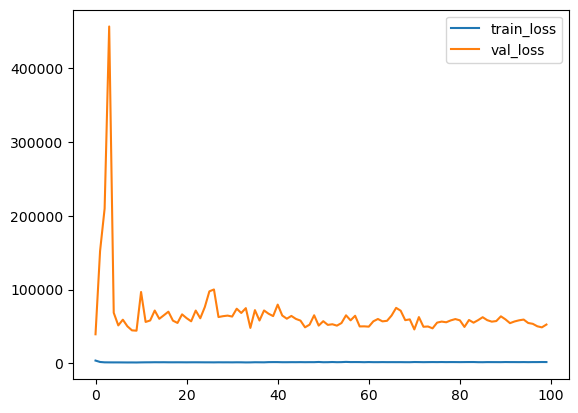

In [15]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

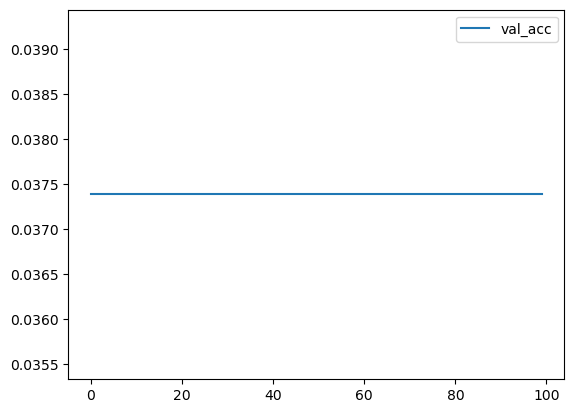

In [16]:
from matplotlib import pyplot as plt
plt.plot(validation_acc, label='val_acc')
plt.legend()
plt.show